In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Final Custom CNN with Accuracy Improvements and Grad-CAM
This notebook includes:
- Your original custom CNN (preserved structure)
- Accuracy improvements (BatchNorm, Dropout, Augmentation)
- Training with 20 Epochs and Early Stopping
- Grad-CAM Visualization
- Accuracy, Precision, Recall, F1, Confusion Matrix, ROC Curve


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import time
import seaborn as sns
import cv2
import torch.nn.functional as F


In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [9]:
# ✅ Accuracy improvement: Data Augmentation added here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

data_path = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer"

full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
# ✅ DATASET SPLITTING (TRAIN / VALIDATION / TEST)
from torch.utils.data import random_split, DataLoader

# Assuming full_dataset is already defined
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# ✅ Print dataset sizes
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Total dataset size: 25000
Training set size: 17500
Validation set size: 3750
Test set size: 3750


In [12]:
# ✅ Custom CNN with BatchNorm and Dropout added for accuracy
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(class_names)).to(device)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
from copy import deepcopy

num_epochs = 20  # ✅ Increased to 20

best_loss = np.inf
patience_counter = 0

train_losses, val_losses = [], []

best_model_wts = deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # ✅ Now this is at the correct indentation level:
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", flush=True)



Epoch 1/20 | Train Loss: 2.5672 | Val Loss: 0.5196
Epoch 2/20 | Train Loss: 0.7003 | Val Loss: 0.6134
Epoch 3/20 | Train Loss: 0.6633 | Val Loss: 0.5449
Epoch 4/20 | Train Loss: 0.6571 | Val Loss: 0.5927
Epoch 5/20 | Train Loss: 0.6129 | Val Loss: 0.4112
Epoch 6/20 | Train Loss: 0.6095 | Val Loss: 0.4412
Epoch 7/20 | Train Loss: 0.5686 | Val Loss: 0.6045
Epoch 8/20 | Train Loss: 0.5746 | Val Loss: 0.3773
Epoch 9/20 | Train Loss: 0.5320 | Val Loss: 0.4412
Epoch 10/20 | Train Loss: 0.5240 | Val Loss: 0.3902
Epoch 11/20 | Train Loss: 0.5238 | Val Loss: 0.7140
Epoch 12/20 | Train Loss: 0.5120 | Val Loss: 0.3319
Epoch 13/20 | Train Loss: 0.4821 | Val Loss: 0.2969
Epoch 14/20 | Train Loss: 0.4889 | Val Loss: 0.2844
Epoch 15/20 | Train Loss: 0.4750 | Val Loss: 0.2517
Epoch 16/20 | Train Loss: 0.4580 | Val Loss: 0.5683
Epoch 17/20 | Train Loss: 0.4421 | Val Loss: 0.3043
Epoch 18/20 | Train Loss: 0.4518 | Val Loss: 0.2395
Epoch 19/20 | Train Loss: 0.4076 | Val Loss: 0.3376
Epoch 20/20 | Train L

              precision    recall  f1-score   support

  cervix_dyk       0.94      0.98      0.96       782
  cervix_koc       0.98      0.83      0.90       710
  cervix_mep       0.96      0.90      0.93       837
  cervix_pab       0.96      1.00      0.98       679
  cervix_sfi       0.84      0.95      0.89       742

    accuracy                           0.93      3750
   macro avg       0.94      0.93      0.93      3750
weighted avg       0.94      0.93      0.93      3750



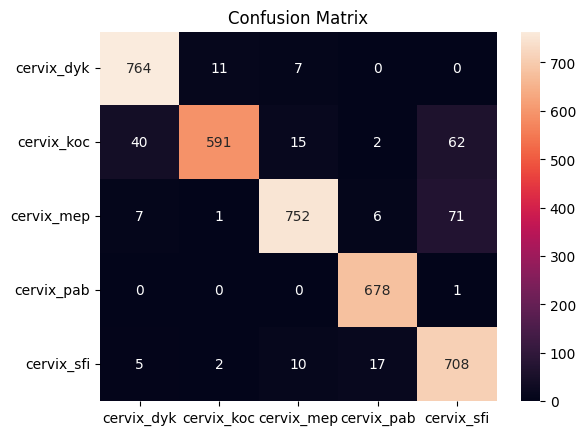

In [15]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


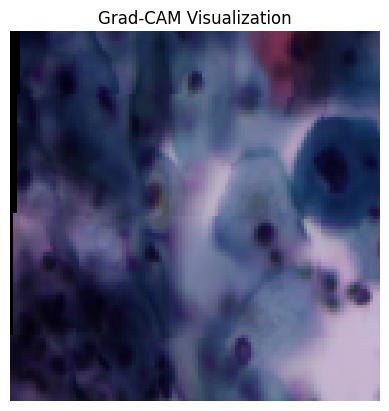

In [16]:
# ✅ Grad-CAM Section
from torchvision.models import resnet18
from torch.autograd import Function

# Pick last conv layer name from model
target_layer = model.conv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor = input_tensor.to(device)

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy()

# Test Grad-CAM on a batch
dataiter = iter(val_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0)

gradcam = GradCAM(model, target_layer)
heatmap = gradcam.generate(img)

# Plot Grad-CAM
img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()


In [20]:

# --- Evaluation: test time, per-class accuracy, classification report, ROC & AUC ---
t1 = time.time()
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
test_time_sec = time.time() - t1
print("Test time: %.2f seconds" % test_time_sec)
print("Test Accuracy: %.4f | Test Loss: %.4f" % (test_acc, test_loss))

# Predictions
probs = model.predict(test_generator, verbose=0)
y_pred = probs.argmax(axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Confusion Matrix & per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_acc = (np.diag(cm) / np.clip(cm.sum(axis=1), a_min=1, a_max=None))
print("\nPer-class accuracy:")
for i, acc in enumerate(per_class_acc):
    print("  %s: %.4f" % (class_names[i], acc))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ROC Curves & AUC (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label="%s (AUC=%.3f)" % (class_names[i], roc_auc[i]))
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label="micro (AUC=%.3f)" % roc_auc["micro"])
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label="macro (AUC=%.3f)" % roc_auc["macro"])
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


AttributeError: 'CustomCNN' object has no attribute 'evaluate'